# Extract clusters from latent space (LDIM=2)

- Load encoded data
- Load labels if they are not part of encoded data
- Plot lspace clustering for insight
- Try to extract groups of clusters
- Plot classified groups


In [1]:
import os
# workdir = '/gpfs/home3/mizeboud/'
# os.chdir(os.path.join(workdir,'preprocessing/scripts/train-vae/'))
homedir = '/Users/tud500158/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/'
workdir = os.path.join(homedir,'github/AutomatedDamageDetection/')
os.chdir(os.path.join(workdir,'scripts/train-vae/'))
import numpy as np
import tensorflow as tf
import glob
import os
import matplotlib.pyplot as plt

# own modules
# import dataset
import tiles as ts

# from shapely import geometry
from rasterio.features import shapes, geometry_mask
import pathlib
import pandas as pd
import rioxarray as rioxr
import xarray as xr

import geopandas as gpd

print('---- modules imported')
os.chdir(workdir)


---- modules imported


### Define model

In [7]:


# # # -- Model 26jan, first ldim=3
# # path_to_traindir = os.path.join(workdir,'train','2023-01')
# # model_dir = 'model_1674722828_WLKF_100_3_3_64_alpha-5'
# # cutout_size = 100

# # -- model 26 jan, ldim=2 promising
# path_to_traindir = os.path.join(workdir,'train','2023-01')
# model_dir = 'model_1674725058_WLKF_20_2_5_16_alpha-5'
# cutout_size=20

# # # -- model 16 may, ldim=2 extended, alpha=200 --> has no latent space values?
# # path_to_traindir = os.path.join(workdir,'train','2023-05')
# # model_dir = 'model_1684233918_L2_w20_k5_f16_a200'
# # cutout_size=20

# # -- model 16 may, ldim=2 extended, alpha=20
# path_to_traindir = os.path.join(workdir,'train','2023-05')
# model_dir = 'model_1684233861_L2_w20_k5_f16_a20'
# cutout_size=20

# # path_to_model = glob.glob(os.path.join(path_to_traindir , model_dir))
# path_to_model = os.path.join(os.path.expanduser('~'), path_to_traindir , model_dir)
# path_to_model

### Define data tile

In [8]:


# # Training tile
# tileNum = 'tile_140'
# tile_file = '/projects/0/einf512/S2_composite_2019-11-1_2020-3-1/S2_composite_2019-11-1_2020-3-1_tile_140.tif'
# dmg_file = '/projects/0/einf512/NERD/damage_detection/S2_composite_2019-11-1_2020-3-1_tile_140_300m_damageContin.tif'

# # Validation tile:
# # tileNum = 'tile_50'
# # tile_file = "/projects/0/einf512/S2_composite_2019-11-1_2020-3-1/S2_composite_2019-11-1_2020-3-1_tile_50.tif"
# # dmg_file = '/projects/0/einf512/NERD/damage_detection/S2_composite_2019-11-1_2020-3-1_tile_50_300m_damageContin.tif'


# tileName = tile_file.split("/")[-1][:-4] 
# tileName
    

In [2]:

tiles_path = '/projects/0/einf512/S2_composite_2019-11-1_2020-3-1/'
labels_path = '/projects/0/einf512/labels/'
label_type = 'manual'
# local
tiles_path = os.path.join(homedir,'Data/tiles/training_tiles')
labels_path = os.path.join(homedir,'Data/tiles/')

# labels_path = os.path.join(os.path.expanduser('~'), 'data/S1_dmg/')
# # label_type = 'nerd'
# tile_nums = [0, 3, 4, 42, 51, 52, 53, 54, 55, 61, 124, 140, 276, 285, 286] # all tiles in DJF 19-20 tht have mnual labels; # exlcuding 61

# tile_nums = [28, 50, 140]


### Functions

In [3]:
def create_cutouts2(da,cutout_size, normThreshold=None, equalise=False):

    # generate windows
    da = da.rolling(x=cutout_size, y=cutout_size)
    da = da.construct({'x': 'x_win', 'y': 'y_win'}, stride=cutout_size)

    # drop NaN-containing windows
    da = da.stack(sample=('x', 'y'))
    da = da.dropna(dim='sample', how='any')

    # tile_cutouts = da.data.transpose(3, 1, 2, 0) # samples, x_win, y_win, bands: (250000, 20, 20, 3)
    # tile_cutouts_da = da.transpose('sample','x_win','y_win','band')
    
    tile_cutouts_da = da.transpose('sample','x_win','y_win' ,...) # transpose dimensionos; dataArray does nto necessarily need 'band' as dimension
    tile_cutouts = tile_cutouts_da.data
    
    return tile_cutouts, tile_cutouts_da

def plot_lspace_4d(tile_cutouts_da, encoded_data,figsize=(12,10) ):
    z0 = encoded_data[:,0]
    z1 = encoded_data[:,1]
    z2 = encoded_data[:,2]
    z3 = encoded_data[:,3]

    # add z0 only to (sample,x,y. )
    L_space_xy_z0 =  tile_cutouts_da.isel(band=[0],x_win=0,y_win=0).copy(deep=True, data=np.expand_dims(z0,axis=1) ) #.unstack()
    L_space_xy_z1 =  tile_cutouts_da.isel(band=[0],x_win=0,y_win=0).copy(deep=True, data=np.expand_dims(z1,axis=1) ) #.unstack()
    L_space_xy_z2 =  tile_cutouts_da.isel(band=[0],x_win=0,y_win=0).copy(deep=True, data=np.expand_dims(z2,axis=1) ) #.unstack()
    L_space_xy_z3 =  tile_cutouts_da.isel(band=[0],x_win=0,y_win=0).copy(deep=True, data=np.expand_dims(z3,axis=1) ) #.unstack()

    fig,axes = plt.subplots(2,2,figsize=figsize) # (20,10)

    L_space_xy_z0.unstack().isel(band=0).plot.imshow(ax=axes[0,0],x='x',cmap='RdBu',cbar_kwargs={'fraction':0.04}) #,vmin=-0.1,vmax=0.1, # vmin=-2 vmax=2
    axes[0,0].set_title('z0')
    axes[0,0].set_aspect('equal')

    L_space_xy_z1.unstack().isel(band=0).plot.imshow(ax=axes[0,1],x='x',cmap='RdBu',cbar_kwargs={'fraction':0.04}) # vmin=-0.1,vmax=0.1,
    axes[0,1].set_title('z1')
    axes[0,1].set_aspect('equal')

    L_space_xy_z2.unstack().isel(band=0).plot.imshow(ax=axes[1,0],x='x',cmap='RdBu',cbar_kwargs={'fraction':0.04}) # vmin=-2 vmax=2
    axes[1,0].set_title('z2')
    axes[1,0].set_aspect('equal')

    L_space_xy_z3.unstack().isel(band=0).plot.imshow(ax=axes[1,1],x='x',cmap='RdBu',cbar_kwargs={'fraction':0.04}) # vmin=-2 vmax=2
    axes[1,1].set_title('z3')
    axes[1,1].set_aspect('equal')

    # fig.savefig(os.path.join(path_to_traindir , model_dir, tileNum + '_spatial_lspace'))
    # fig.savefig(os.path.join(path_to_model, tileNum + '_spatial_lspace' + '_epoch'+str(epoch_num) ))
    
    
def plot_lspace_2d(tile_cutouts_da, encoded_data ,figsize=(12,10)):
    
    z0 = encoded_data[:,0]
    z1 = encoded_data[:,1]

    # add z0 only to (sample,x,y. )
    L_space_xy_z0 =  tile_cutouts_da.isel(band=[0],x_win=0,y_win=0).copy(deep=True, data=np.expand_dims(z0,axis=1) ) #.unstack()
    L_space_xy_z1 =  tile_cutouts_da.isel(band=[0],x_win=0,y_win=0).copy(deep=True, data=np.expand_dims(z1,axis=1) ) #.unstack()

    fig,axes = plt.subplots(1,2,figsize=figsize) # (20,10)

    L_space_xy_z0.unstack().isel(band=0).plot.imshow(ax=axes[0],x='x',cmap='RdBu',cbar_kwargs={'fraction':0.04}) #,vmin=-0.1,vmax=0.1, # vmin=-2 vmax=2
    axes[0].set_title('z0')
    axes[0].set_aspect('equal')

    L_space_xy_z1.unstack().isel(band=0).plot.imshow(ax=axes[1],x='x',cmap='RdBu',cbar_kwargs={'fraction':0.04}) # vmin=-0.1,vmax=0.1,
    axes[1].set_title('z1')
    axes[1].set_aspect('equal')

    # fig.savefig(os.path.join(path_to_traindir , model_dir, tileNum + '_spatial_lspace'))
    # fig.savefig(os.path.join(path_to_model, tileNum + '_spatial_lspace' + '_epoch'+str(epoch_num) ))


def plot_latentspace_clusters( embedded_data,labels, clabel='label' ,figsize=(8,8) ,ax=None, cmap='cividis_r',alpha=1):    
    marksize = 2
    if len(labels.shape)>1:
        labels = np.squeeze(labels)
    
    # sort data with label value so that labelled pixes will be on top
    embedded_data = embedded_data[ np.argsort(labels),:] #,np.argsort(labels)]
    labels = np.sort(labels,axis=0)
    
    # split data in points with (no) label value
    z0 = embedded_data[:, 0]
    z1 = embedded_data[:, 1]
    
    if ax is None:
        fig, ax = plt.subplots(1, figsize=figsize )
    s1 = ax.scatter(z0, z1, c=labels, s=marksize, cmap=cmap,alpha=alpha) # also add size for scatter point
    # s0 = ax1.scatter(z0_label0, z1_label0, color='red', s=marksize, ) # also add size for scatter point
    # s1 = ax1.scatter(z0_label1, z1_label1, c=labels[labels>0], s=marksize, cmap='cividis_r') # also add size for scatter point
    ax.set_xlabel("z[0]"); 
    ax.set_ylabel("z[1]");
    fig = plt.gcf()
    fig.colorbar(s1,ax=ax,label=clabel); 
    return ax


def load_nerd_dmg_tile_labels(dmg_file,tile_da, cutout_size):
    ''' ----------
    Load Labels: processed dmg
    ------------'''
    
    tile_dmg = rioxr.open_rasterio(dmg_file).astype("float32")

    # interpolate dmg to same resolution as tile (to link as labels)
    tile_dmg_int = tile_dmg.isel(band=0).interp_like(tile_da.isel(band=0))
    tile_dmg_int= tile_dmg_int.fillna(0).expand_dims(dim='band') # fill nan with zeros and add band-dim
            
    label_cutouts, label_cutouts_da = create_cutouts2(tile_dmg_int, cutout_size)  
    labels_ldim = label_cutouts.sum(axis=1).sum(axis=1) # (Nsamples, x_win, y_win, 1) to (Nsamples,1)  
    labels_ldim_da = label_cutouts_da.sum(axis=1).sum(axis=1) # (Nsamples, x_win, y_win, 1) to (Nsamples,1)      
    return labels_ldim, labels_ldim_da


def normalise_and_equalise(da,normThreshold=None,equalise=False):
    
    # normalize
    if normThreshold is not None:
        da = (da + 0.1) / (normThreshold + 1)
        da = da.clip(max=1)
    
    if equalise:
        # hist equalist
        n_bands = da['band'].shape[0]
        all_band_eq=np.empty(da.shape)

        for band_i in range(n_bands): # perform adaptive normalisation per band
            band_data = da.isel(band=band_i)
            band_data_eq = skimage_exposure.equalize_adapthist(band_data, clip_limit=0.03)
            all_band_eq[band_i] = np.expand_dims(band_data_eq,axis=0)

        da = da.copy(data=all_band_eq) # overwrite data in dataArray
    
    return da

# Function for 2D -- make to 3D
def plot_latentspace_clusters_3d( embedded_data,labels, clabel='label' ,figsize=(10,6), azim=-80,elev=20, add_line_3d=None ):    
    marksize = 2
    if len(labels.shape)>1:
        labels = np.squeeze(labels)
    
    # sort data with label value so that labelled pixes will be on top
    # embedded_data = embedded_data[ np.argsort(labels),:] #,np.argsort(labels)]
    # labels = np.sort(labels,axis=0)
    
    # split data in points with (no) label value
    z0 = embedded_data[np.argsort(labels), 0]
    z1 = embedded_data[np.argsort(labels), 1]
    z2 = embedded_data[np.argsort(labels), 2]
    labels = np.sort(labels,axis=0)
    
    fig = plt.figure(figsize=figsize, layout="constrained")
    spec = fig.add_gridspec(3, 2)
    
    # -- 3d plot
    ax0 = fig.add_subplot(spec[:,0], projection='3d')
    s1 = ax0.scatter(z0, z1, z2, c=labels, cmap='cividis_r',s=marksize) # also add size for scatter point
    ax0.set_xlabel('z0'); ax0.set_ylabel('z1'); ax0.set_zlabel('z2')
    # decide on camera look angle
    ax0.elev = elev # default 30;  top/bottom view
    ax0.azim = azim # default -60; xaxis rotation
    
    if add_line_3d is not None:
        xline, yline, zline = add_line_3d
        ax0.plot3D(xline, yline, zline, 'r--',linewidth=2.5)
        ax0.set_xlim( [np.min(z0), np.max(z0)])
        ax0.set_ylim( [np.min(z1), np.max(z1)])
        ax0.set_zlim( [np.min(z2), np.max(z2)])

    # -- left view: x,y
    ax01 = fig.add_subplot(spec[0, 1])#, projection='3d')
    ax01.elev = 0 # default 30;  top/bottom view
    ax01.azim = -90 # default -60; xaxis rotation
    # s1 = ax01.scatter(z0, z1, z2, c=labels, cmap='cividis_r') # also add size for scatter point
    s1 = ax01.scatter(z0 , z1, c=labels, s=marksize, cmap='cividis_r') # also add size for scatter point
    ax01.set_title('z0 z1') ; ax01.grid('on')
    
    if add_line_3d is not None:
        xline, yline, zline = add_line_3d
        ax01.plot(xline, yline, 'r--',linewidth=2.5)
        # ax01.set_xlim( [np.min(z0), np.max(z0)])
        # ax01.set_ylim( [np.min(z1), np.max(z1)])
        
    
    # -- right view
    ax11 = fig.add_subplot(spec[1, 1])#projection='3d')
    ax11.elev = 0 # default 30;  top/bottom view
    ax11.azim = 0 # default -60; xaxis rotation
    s1 = ax11.scatter(z1, z2, c=labels, s=marksize,  cmap='cividis_r') # also add size for scatter point
    ax11.set_title('z1 z2') ; ax11.grid('on')
    
    # -- top view
    ax21 = fig.add_subplot(spec[2, 1])#projection='3d')
    ax21.elev = 90 # default 30;  top/bottom view
    ax21.azim = 0 # default -60; xaxis rotation
    s1 = ax21.scatter(z0, z2, c=labels, s=marksize,  cmap='cividis_r') # also add size for scatter point
    ax21.set_title('z0 z2'); ax21.grid('on')
    
    # fig.colorbar(s1,ax=ax,label=clabel,fraction=0.045,shrink=0.6); 
    return fig

def mask_data(data, mask_file):
    mask_poly = gpd.read_file(mask_file).to_crs(epsg=3031)
    # gdf = mask_poly.unary_union 
    # mask = data #.copy(data=np.ones_like(data.values)) # set up img with only 1 vluess
    # masked_data = data.rio.clip(mask_poly.unary_union, mask_poly.crs, drop=False, invert=False) # mask (raster)
    masked_data = data.rio.clip(mask_poly.geometry, mask_poly.crs, drop=False, invert=False) # mask (raster)
    return masked_data


def create_cutouts3(da,cutout_size, dropna=True, fillna=False):

    # generate windows
    da = da.rolling(x=cutout_size, y=cutout_size)
    da = da.construct({'x': 'x_win', 'y': 'y_win'}, stride=cutout_size)

    # drop NaN-containing windows
    da = da.stack(sample=('x', 'y'))
    if dropna:
        da = da.dropna(dim='sample', how='any')
    if fillna: # can be either 'True' or a value (float/int). If no value is specified, use -999
        if isinstance(fillna,bool):
            fillna=-999
        da = da.fillna(fillna)

    # tile_cutouts = da.data.transpose(3, 1, 2, 0) # samples, x_win, y_win, bands: (250000, 20, 20, 3)
    # tile_cutouts_da = da.transpose('sample','x_win','y_win','band')
    
    tile_cutouts_da = da.transpose('sample','x_win','y_win' ,...) # transpose dimensionos; dataArray does nto necessarily need 'band' as dimension
    # tile_cutouts = tile_cutouts_da.data
    
    return tile_cutouts_da



## Define model

In [4]:


# # -- Model 26jan, first ldim=3
# path_to_traindir = os.path.join(workdir,'train','2023-01')
# model_dir = 'model_1674722828_WLKF_100_3_3_64_alpha-5'
# cutout_size = 100

# -- model 26 jan, ldim=2 promising
# path_to_traindir = os.path.join(workdir,'train','2023-01')
# model_dir = 'model_1674725058_WLKF_20_2_5_16_alpha-5'
# cutout_size=20

# -- model 16 may, ldim=2 extended
# path_to_traindir = os.path.join(workdir,'train','2023-05')
# model_dir = 'model_1684233759_L2_w20_k5_f16_a5'
# cutout_size=20

# # -- model 16 may, ldim=2 extended, alpha=200 --> has no latent space values?
# path_to_traindir = os.path.join(workdir,'train','2023-05')
# model_dir = 'model_1684233918_L2_w20_k5_f16_a200'
# cutout_size=20

# -- model 16 may, ldim=2 extended, alpha=20
path_to_traindir = os.path.join(workdir,'train','2023-05')
model_dir = 'model_1684233861_L2_w20_k5_f16_a20'
cutout_size=20


# path_to_model = glob.glob(os.path.join(path_to_traindir , model_dir))
path_to_model = os.path.join(os.path.expanduser('~'), path_to_traindir , model_dir)
path_to_model

# local: 
path_to_model = os.path.join('/Users/tud500158/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/github/AutomatedDamageDetection/training/2023-05/',model_dir)
path_to_model

'/Users/tud500158/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/github/AutomatedDamageDetection/training/2023-05/model_1684233861_L2_w20_k5_f16_a20'

In [30]:
# encoder_dirs
# path_to_model
# glob.glob(os.path.join(path_to_model,'encoder*'))
# os.listdir(labels_path)

## Load encoded data; labelled training tiles

---- Loading S2_composite_2019-11-1_2020-3-1_tile_124


2023-06-16 13:05:08.860394: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


loaded manual values: min 0.0 max 400.0
loaded nerd values: min 0.0 max 134.12560414505143
---- Loading S2_composite_2019-11-1_2020-3-1_tile_140
loaded manual values: min 0.0 max 400.0
loaded nerd values: min 0.0 max 93.88689421491827
All data: (781250, 2) 
All labels: (1,)


<xarray.Dataset>
Dimensions:  (samples: 781250, ldim: 2, label: 2)
Coordinates:
  * samples  (samples) int64 0 1 2 3 4 5 ... 390620 390621 390622 390623 390624
  * ldim     (ldim) int64 0 1
  * label    (label) int64 0 1
Data variables:
    data     (samples, ldim) float32 -0.8982 -0.004792 ... -0.8917 -0.004504
    labels   (samples, label) float64 0.0 12.27 0.0 16.95 ... 0.0 0.0 0.0 0.0

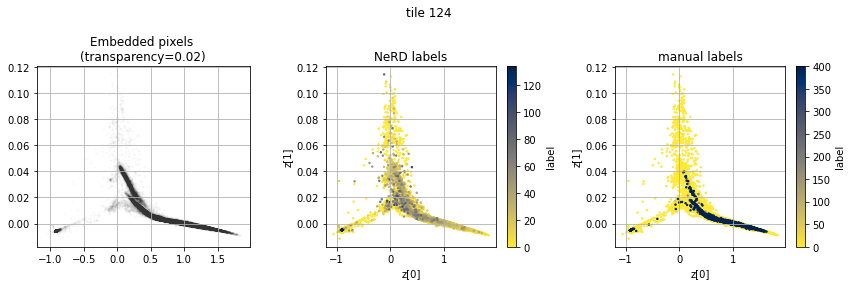

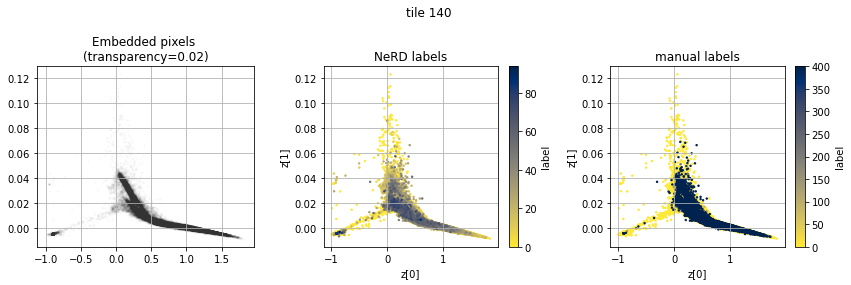

In [5]:

''' ----------
Load model/encoder
------------'''

# -- load encoder
encoder_dirs = glob.glob(os.path.join(path_to_model,'encoder*'))
encoder_dirs.sort()

# -- (A) select the last encoder

path_to_encoder_epoch = encoder_dirs[-1]

# -- (B) load multiple tiles & labels
encoded_data_all=[]
encoded_labels_manual=[]
encoded_labels_nerd = []
encoded_labels_all=[]

# tile_nums=[140]
tile_nums = [0, 3, 4, 42, 51, 52, 53, 54, 55, 124, 140, 276, 285, 286] # all tiles in DJF 19-20 tht have mnual labels; # exlcuding 61
tile_nums = [124,140,285]
# tile_nums = [285]
# tile_nums = [28, 50, 140]
tile_nums = [124,140]
for tileNum in tile_nums:
        
    tile_file = os.path.join(tiles_path,'S2_composite_2019-11-1_2020-3-1_tile_' + str(tileNum) + '.tif')
    tileName = tile_file.split("/")[-1][:-4] # vb: 'S2_composite_2019-11-1_2020-3-1_tile_124'
    print('---- Loading ' + tileName )

    epoch_num = path_to_encoder_epoch.split('_')[-1]
    encoder = tf.keras.models.load_model(path_to_encoder_epoch,compile=False) # compile=True does not work
    
    # Get latent_dim (of sampling layer)
    latent_dim = encoder.layers[-1].output_shape[-1] 

    ''' ----------
    Load encoded input
    ------------'''

    encoded_data_file = os.path.join(path_to_model, tileName + "_encoded" + '_epoch'+str(epoch_num) +".npy")
    if os.path.exists(encoded_data_file):
        # read file
        encoded_data = np.load(encoded_data_file) # np.array
        # to xr.dataArray
        encoded_data = xr.DataArray(data=encoded_data, dims=['samples','ldim'], 
                             coords={'samples':np.arange(0,len(encoded_data)),'ldim':np.arange(0,latent_dim)}).to_dataset(name='data')
        


        ''' ----------
        Load labels
        ------------'''

        label_type = 'manual'
        label_file = os.path.join(labels_path,'labels_encoded', 'labels_'+ label_type + '_w' + str(cutout_size) + '_' + tileName + '_ldim.npy' )
        if os.path.exists(label_file):
            labels_np1 = np.load(label_file ) # load 'encoded' labels
            print('loaded {} values: min {} max {}'.format(label_type, np.min(labels_np1),np.max(labels_np1)) )
            labels1 = xr.DataArray(data=labels_np1, dims=['samples','label'],
                                 coords={'samples':np.arange(0,len(labels_np1)),'label':np.arange(0,1)}).to_dataset(name='labels')
            encoded_labels_manual.append(labels1)

        label_type = 'nerd'
        label_file = os.path.join(labels_path,'labels_encoded', 'labels_'+ label_type + '_w' + str(cutout_size)  + '_' + tileName + '_ldim.npy')
        if os.path.exists(label_file):
            labels_np2 = np.load(label_file ) # load 'encoded' labels
            print('loaded {} values: min {} max {}'.format(label_type, np.min(labels_np2),np.max(labels_np2)) )
            labels2 = xr.DataArray(data=labels_np2, dims=['samples','label'],
                                 coords={'samples':np.arange(0,len(labels_np2)),'label':np.arange(1,2)}).to_dataset(name='labels')
            encoded_labels_nerd.append(labels2)

        ''' MERGE DATA ''' 

        data_labels = xr.merge([labels1,labels2])
        data_da = xr.merge([encoded_data, labels1, labels2])

        encoded_labels_all.append(data_labels)
        encoded_data_all.append(data_da)
        
        ''' PLOT PER TILE '''
        
        fig,axs=plt.subplots(1,3,figsize=(12,4))
        ax=axs[0]
        alpha=0.02
        ax.scatter(encoded_data['data'].isel(ldim=0),encoded_data['data'].isel(ldim=1), s=2,
                   alpha=alpha,color=[0.2, 0.2, 0.2], )# cividis_r
        ax.grid('on'); 
        ax.set_title('Embedded pixels \n(transparency={})'.format(alpha))

        ax=axs[1]
        plot_latentspace_clusters(encoded_data['data'],labels_np2,figsize=(5,5), ax=ax,cmap='cividis_r')#,alpha=0.1) # cividis_r
        ax.grid('on'); 
        ax.set_title('NeRD labels'.format(tile_nums))

        ax=axs[2]
        plot_latentspace_clusters(encoded_data['data'],labels_np1,figsize=(5,5), ax=ax,cmap='cividis_r')#,alpha=0.01)
        ax.grid('on'); 
        ax.set_title('manual labels'.format(tile_nums))

        fig.suptitle('tile {}'.format(tileNum) )

        fig.tight_layout()
        # fig.show()
        # fig.savefig(os.path.join(path_to_model,'tile_{}_embedded_labels.png'.format(tileNum)),bbox_inches='tight')
        
    
#     # make xarray of data
    
#     # data_da = xr.merge([encoded_data, labels])
#     # data_da = encoded_data;

#     # store all dataArrays in a list, to concat later
#     # encoded_data_all.append(data_da)

    
# combine all datasamples (incl labels) from all tiles 
data_da_all = xr.concat(encoded_data_all,dim='samples')
encoded_labels_manual = xr.concat(encoded_labels_manual,dim='samples')
encoded_labels_nerd = xr.concat(encoded_labels_nerd,dim='samples')
encoded_labels_all = xr.concat(encoded_labels_all,dim='samples')

print("All data: {} \nAll labels: {}".format(data_da_all['data'].shape,encoded_labels_manual['label'].shape))#,data_da_all['labels'].shape))
# print("All data: {} \nAll labels: {}".format())
data_da_all # N,3 
# labels_da_all # N,1
# 31250 for 2 tiles

data_labels
data_da_all
    

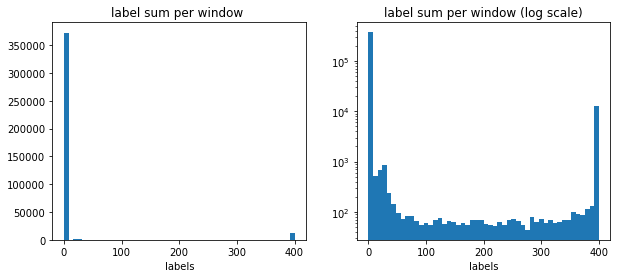

In [58]:

fig, axs=plt.subplots(1,2,figsize=(10,4))
ax = axs[0]
labels1['labels'].plot.hist(bins=50,ax=ax)
ax.set_title('label sum per window ')
ax= axs[1]
labels1['labels'].plot.hist(bins=50,ax=ax)
ax.set_title('label sum per window (log scale)')
ax.set_yscale('log')
# np.unique(labels1['labels'])

#### Plot only labelled px to see where they are

Text(0.5, 1.0, 'Embedded pixels \n label=1')

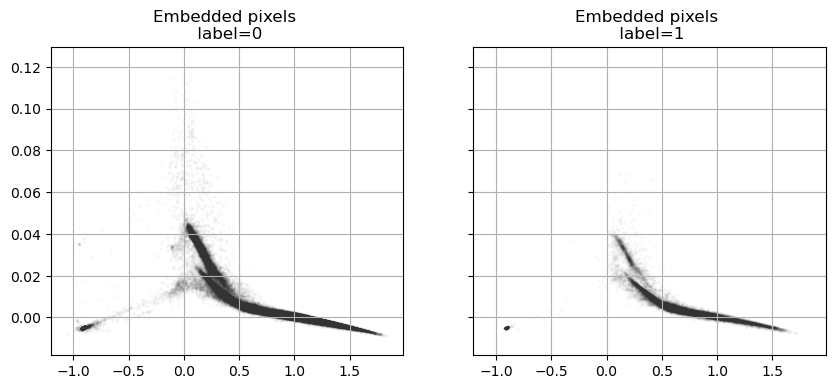

In [8]:
## FOr the last loaded tile (140):
idx_ManL_1 = (labels_np1 > 0).ravel() # 18776 samples
encoded_data_ManL1 = encoded_data['data'].values[idx_ManL_1,:] # 18776 samples
encoded_data_ManL0 = encoded_data['data'].values[~idx_ManL_1,:] # 18776 samples

## For all tiles:
idx_ManL_1 = (encoded_labels_manual['labels'].values > 0).ravel() # 781250 samples
encoded_data_ManL1 = data_da_all['data'].values[idx_ManL_1,:] # 781250 samples
encoded_data_ManL0 = data_da_all['data'].values[~idx_ManL_1,:] 


fig,axs=plt.subplots(1,2,figsize=(10,4),sharex=True,sharey=True)
ax=axs[0]
alpha=0.02
ax.scatter(encoded_data_ManL0[:,0],encoded_data_ManL0[:,1], s=2,
           alpha=alpha,color=[0.2, 0.2, 0.2], )# cividis_r
ax.grid('on'); 
ax.set_title('Embedded pixels \n label=0'.format(alpha))

ax=axs[1]
alpha=0.02
ax.scatter(encoded_data_ManL1[:,0],encoded_data_ManL1[:,1], s=2,
           alpha=alpha,color=[0.2, 0.2, 0.2], )# cividis_r
ax.grid('on'); 
ax.set_title('Embedded pixels \n label=1'.format(alpha))



#### Plot label colors

In [9]:

# %matplotlib inline

# fig,axs=plt.subplots(1,2,figsize=(8,4))

# ax=axs[0]
# plot_latentspace_clusters(data_da_all['data'],encoded_labels_nerd['labels'].values,figsize=(5,5), ax=ax,cmap='cividis_r')#,alpha=0.1) # cividis_r
# ax.grid('on'); 
# ax.set_title('NeRD labels'.format(tile_nums))

# ax=axs[1]
# plot_latentspace_clusters(data_da_all['data'],encoded_labels_manual['labels'].values,figsize=(5,5), ax=ax,cmap='cividis_r')#,alpha=0.01)
# ax.grid('on'); 
# ax.set_title('manual labels'.format(tile_nums))

# fig.suptitle('tiles {}\n ..'.format(tile_nums) )

# fig.tight_layout()


### Clustering 

In [10]:

# %matplotlib inline

# fig,axs=plt.subplots(1,2,figsize=(8,4))

# ax=axs[0]
# plot_latentspace_clusters(data_da_all['data'],encoded_labels_nerd['labels'].values,figsize=(5,5), ax=ax,cmap='cividis_r')#,alpha=0.1) # cividis_r
# ax.grid('on'); 
# ax.set_title('NeRD labels'.format(tile_nums))

# ax=axs[1]
# plot_latentspace_clusters(data_da_all['data'],encoded_labels_manual['labels'].values,figsize=(5,5), ax=ax,cmap='cividis_r')#,alpha=0.01)
# ax.grid('on'); 
# ax.set_title('manual labels'.format(tile_nums))

# fig.suptitle('tiles {}\n ..'.format(tile_nums) )

# fig.tight_layout()

## Check clustering of all labeled (test) tiles

In [11]:
# # tile_nums = [102,110,114,123,124]  # train-tiles (selection), no labels
# tile_nums = [0, 3, 4, 42, 51, 52, 53, 54, 55, 124, 140, 276, 285, 286] # all tiles in DJF 19-20 tht have mnual labels; # exlcuding 61

# encoded_data_all=[]
# encoded_labels_manual=[]

# for tileNum in tile_nums:
        
#     tile_file = os.path.join(tiles_path,'S2_composite_2019-11-1_2020-3-1_tile_' + str(tileNum) + '.tif')
#     tileName = tile_file.split("/")[-1][:-4] # vb: 'S2_composite_2019-11-1_2020-3-1_tile_124'
#     print('---- Loading ' + tileName )

#     epoch_num = path_to_encoder_epoch.split('_')[-1]
#     encoder = tf.keras.models.load_model(path_to_encoder_epoch,compile=False) # compile=True does not work
    
#     # Get latent_dim (of sampling layer)
#     latent_dim = encoder.layers[-1].output_shape[-1] 

#     ''' ----------
#     Load encoded input
#     ------------'''

#     encoded_data_file = os.path.join(path_to_model, tileName + "_encoded" + '_epoch'+str(epoch_num) +".npy")
#     if os.path.exists(encoded_data_file):
#         # read file
#         encoded_data = np.load(encoded_data_file) # np.array
#         # to xr.dataArray
#         encoded_data = xr.DataArray(data=encoded_data, dims=['samples','ldim'], 
#                              coords={'samples':np.arange(0,len(encoded_data)),'ldim':np.arange(0,latent_dim)}).to_dataset(name='data')
        
#         encoded_data_all.append(encoded_data)
    
#     ''' ----------
#     Load labels
#     ------------'''

#     label_type = 'manual'
#     label_file = os.path.join(labels_path,'labels_encoded', 'labels_'+ label_type + '_w' + str(cutout_size) + '_' + tileName + '_ldim.npy' )
#     if os.path.exists(label_file):
#         labels_np = np.load(label_file ) # load 'encoded' labels
#         print('loaded {} values: min {} max {}'.format(label_type, np.min(labels_np),np.max(labels_np)) )
#         labels1 = xr.DataArray(data=labels_np, dims=['samples','label'],
#                              coords={'samples':np.arange(0,len(labels_np)),'label':np.arange(0,1)}).to_dataset(name='labels')
#         encoded_labels_manual.append(labels1)
            

# encoded_labels_manual = xr.concat(encoded_labels_manual,dim='samples')
# encoded_data_all = xr.concat(encoded_data_all,dim='samples')
# encoded_labels_manual

In [12]:
# fig,axs=plt.subplots(1)
# ax=axs#[1]
# plot_latentspace_clusters(encoded_data_all['data'],encoded_labels_manual['labels'].values,figsize=(5,5), ax=ax,cmap='cividis_r')#,alpha=0.01)
# ax.grid('on'); 
# ax.set_title('all labelled tiles')


## Check l-space values of all TRAIN tiles (without labels)

In [13]:

# # tile_nums=[140]
# # tile_nums = [0, 3, 4, 42, 51, 52, 53, 54, 55, 124, 140, 276, 285, 286] # all tiles in DJF 19-20 tht have mnual labels; # exlcuding 61
# # tile_nums = [276,  51, 52, 53,54,55] # test-tiles: with labels
# tile_nums = [102,110,114,123,124]  # train-tiles (selection), no labels

# fig,axs=plt.subplots(2,3,figsize=(15,10))
# r=0;c=0
# for tileNum in tile_nums:
        
#     tile_file = os.path.join(tiles_path,'S2_composite_2019-11-1_2020-3-1_tile_' + str(tileNum) + '.tif')
#     tileName = tile_file.split("/")[-1][:-4] # vb: 'S2_composite_2019-11-1_2020-3-1_tile_124'
#     print('---- Loading ' + tileName )

#     epoch_num = path_to_encoder_epoch.split('_')[-1]
#     encoder = tf.keras.models.load_model(path_to_encoder_epoch,compile=False) # compile=True does not work
    
#     # Get latent_dim (of sampling layer)
#     latent_dim = encoder.layers[-1].output_shape[-1] 

#     ''' ----------
#     Load encoded input
#     ------------'''

#     encoded_data_file = os.path.join(path_to_model, tileName + "_encoded" + '_epoch'+str(epoch_num) +".npy")
#     if os.path.exists(encoded_data_file):
#         # read file
#         encoded_data = np.load(encoded_data_file) # np.array
#         # to xr.dataArray
#         encoded_data = xr.DataArray(data=encoded_data, dims=['samples','ldim'], 
#                              coords={'samples':np.arange(0,len(encoded_data)),'ldim':np.arange(0,latent_dim)}).to_dataset(name='data')
        
#         # plot lspace of different tiles
#         # plt.figure()
#         print(encoded_data['data'].values.shape)
#         ax=axs[r,c]
#         ax.scatter( encoded_data['data'].values[:,0], encoded_data['data'].values[:,1],s=2 )
#         # plot_latentspace_clusters(encoded_data['data'].values,np.ones(encoded_data['data'].values.shape),figsize=(5,5), ax=ax,
#         #                           cmap='cividis_r')#,alpha=0.01)
#         ax.set_title('tile '+str(tileNum))
#         c+=1
#         if c==3:
#             c=0
#             r+=1
            
# fig.tight_layout()

## Load and embed locally

In [24]:
# some config settings
oceanmask_file = os.path.join(homedir,'Data/ne_10m_antarctic_ice_shelves_polys/ne_10m_antarctic_ice_shelves_polys.shp')  
catalog_path = os.path.join(homedir,'Data/tiles/')
labels_path = os.path.join(homedir,'Data/tiles/labels_EPSG4326/')
bands = None # [0,1,2]  
normThreshold=[10000]
adaptHist=True
epochs=-1
label_type = 'manual'

In [22]:
''' ----------
Load Labels: shapefiles
------------'''

# # read tile catalog to be able to get CRS and filter labels to same date
catalog = ts._read_tile_catalog(catalog_path)
tiles = ts._catalog_to_geodataframe(catalog)

labels = ts._read_labels(labels_path, verbose=True)
labels = labels.to_crs(tiles.crs)  # make sure same CRS is used. NB: at this stage, 

# IF LABELS HAVE NO DATE (new version --> to update this in the shapefile): assume 2020-01-01
# try:
#     labels.Date
# except AttributeError:
#     labels['Date'] = pd.to_datetime('2020-01-01')
idx_NaT = ~labels['Date'].notnull() # all NaT indices are 'True'
labels.loc[idx_NaT,'Date'] = pd.to_datetime('2020-01-01')

# select the only labels matching the tiles timespan
labels = ts._filter_labels(labels,
                        tiles.start_datetime.min(),
                        tiles.end_datetime.max())

## Create GeoSeries from labels.geometry
label_polys = gpd.GeoSeries(labels.geometry,crs=labels.crs) # Combine all geometries to one GeoSeries, with the 


Labels successfully read from 18 files
Selecting 996 out of 1274 labels


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [25]:

from skimage import exposure as skimage_exposure

tile_nums = [124,140]

for tileNum in tile_nums:
    
    tile_file = os.path.join(tiles_path,'S2_composite_2019-11-1_2020-3-1_tile_' + str(tileNum) + '.tif')
    tileName = tile_file.split("/")[-1][:-4] # vb: 'S2_composite_2019-11-1_2020-3-1_tile_124'
    print('----\n Processing ' + tileName +'\n')

    
    ''' ----------
    Create cut-outs
        Actually read the tile, make cutouts, linked with labeldata

    Update: do not link shapefile laabldata; now read same-tile NERD output
    ------------'''

    # read tile - floats are required to mask with NaN's
    da = rioxr.open_rasterio(tile_file).astype("float32")

    # # select bands
    # if bands is not None:
    #     if type(bands) is not list:
    #         da = da.sel(band=[bands])
    #     else:
    #         da = da.sel(band=bands)


    # ''' ----------
    # Mask ocean
    # ------------'''

    # # mask/clip: if self.mask is not None: [removed; see _generate_cutouts]
    # da = mask_data(da,oceanmask_file)


    # ''' ----------
    # Normalise and Equalise
    # ------------'''
    
    # da = normalise_and_equalise(da,normThreshold=normThreshold[0],equalise=adaptHist)


    ''' ----------
    Add labeldata to cut-outs
    ------------'''
    
    if label_type is not None:
        # if label_type == 'nerd':
        #     ''' ----------
        #     Load Labels: processed dmg
        #     - load NeRD-detected damage tile and interpolate to same grid. 
        #         Every pixel has a value 0 to 1
        #     - Create matching cutouts of damage. 
        #         Get a single damage value per cutout by summing all pixel values within the cutout.
        #     - The damage value can be added as new band to each cutout
        #     ------------'''
        #     dmg_file = os.path.join(dmg_path,'S2_composite_2019-11-1_2020-3-1_tile_' + str(tileNum) + '_300m_damageContin.tif')
        #     crevSig_file = os.path.join(dmg_path,'S2_composite_2019-11-1_2020-3-1_tile_' + str(tileNum) + '_output_10px_crevSig.tif')
        #     # dmg_file = os.path.join(dmg_path,'dmg_SON_2019_tile_' + str(tileNum) + '.tif')
            
        #     # if DMG file not availalbe, try crevSig file. For 30m:10px , threshold =0.04
        #     # ...
        #     if os.path.exists(dmg_file):
        #         data_dmg = rioxr.open_rasterio(dmg_file).astype("float32")
        #     elif os.path.isfile(crevSig_file):
        #         data_crevSig = rioxr.open_rasterio(crevSig_file).astype("float32")
        #         data_dmg = data_crevSig - 0.04   #threshold for S2 30m-10px
        #         data_dmg = data_dmg.where(data_dmg>0, other=0) # only keep positive values
        #     else:
        #         print('No dmg or crevSig file found:\n {} \n {}'.format(dmg_file, crevSig_file))

        #     # interpolate dmg to same resolution as tile (to link as labels)
        #     tile_dmg = data_dmg.isel(band=0).interp_like(da.isel(band=0))
        #     tile_dmg = tile_dmg.fillna(0).expand_dims(dim='band') # fill nan with zeros and add band-dim 

        if label_type == 'manual':

            # # rasterize labels: create mask 
            # labels_tileraster = geometry_mask(label_polys,
            #                                   out_shape=(len(da.y),len(da.x)),
            #                                   transform=da.rio.transform(),invert=True)
            # labels_tileraster = labels_tileraster.astype(np.dtype('uint16')) # np ndarray (x , y)
            # labels_tileraster = np.expand_dims(labels_tileraster,axis=0) # ndarray (1 , x , y) because tiledata shape (3,x,y)
            # # create dataArray from np ndarray
            # tile_dmg = xr.DataArray(
            #             data=labels_tileraster,
            #             dims=["band","x", "y"])

            # remove any empty geometries
            label_polys= label_polys.loc[~label_polys.is_empty]
            
            # create polygon mask
            labels_tileraster = geometry_mask( label_polys.to_crs(da.rio.crs).geometry,
                        out_shape=da.isel(band=0).shape, #ds.geobox.shape,
                        transform=da.rio.transform(), # ds.geobox.affine,
                        all_touched=True,
                        invert=True)
            labels_tileraster = labels_tileraster.astype(np.dtype('uint16')) # np ndarray (x , y)

            tile_dmg = da.isel(band=0).copy( data=labels_tileraster ).expand_dims(dim='band')  # ( y, x)
            tile_dmg.attrs['name']='label'
            tile_dmg.attrs['long_name']='manual_label'

            print('Manual Labels burnt into raster, {}px.'.format(tile_dmg.data.sum())) 

        # Plot labeldata as raster to perform visual check
        # label_raster_file = os.path.join(os.path.expanduser('~'),'data/labels/', 
        #                                 'labels_'+ label_type + '_w' + str(cutout_size) + '_' + tileName + '.png')
        if ~os.path.exists(label_raster_file): 
            fig,ax= plt.subplots(1,figsize=(7,8))
            tile_dmg.isel(band=0).plot.imshow(ax=ax, vmin=0,vmax=1,cbar_kwargs={'fraction':0.045})
            ax.set_title('tile_' + str(tileNum) + ' ' + label_type + ' labels')
            ax.set_aspect('equal')
            # fig.savefig(os.path.join(path_to_traindir , model_dir, tileNum + '_normalised_histEq'))
            # fig.savefig(label_raster_file)

        # Shape labels to latent-dim space
        label_cutouts, _ = create_cutouts2(tile_dmg, cutout_size)  
        labels_ldim = label_cutouts.sum(axis=1).sum(axis=1) # (Nsamples, x_win, y_win, 1) to (Nsamples,1)      
        print('labels {}, min {}, max {}'.format(labels_ldim.shape,np.min(labels_ldim),np.max(labels_ldim)))

        # Save encoded labeldata
        # label_file = os.path.join(labels_path,'labels_encoded', 'labels_'+ label_type + '_w' + str(cutout_size) + '_' + tileName + '_ldim.npy')
        # if ~os.path.exists(label_file):
        #     # label_file = os.path.join(path_to_model, tileName + "_labels_ldim.npy")
        #     # np.save(label_file , labels_ldim) # save 'encoded' labels for later use.
        #     print('..saved labels at {}\n'.format(labels_path))



    ''' ----------
    Load model/encoder
    ------------'''

    # -- laod model
    # model_dirs = glob.glob(path_to_model +'/model_epoch*' )
    # model_dirs.sort()
    # path_to_model_epoch = model_dirs[-1]
    # model = tf.keras.models.load_model(path_to_model_epoch ,compile=False)

    # -- load encoder
    encoder_dirs = glob.glob(os.path.join(path_to_model,'encoder*') )
    encoder_dirs.sort()
    # -- if specified, select a specific (e.g. the last) encoder and redefine the list
    if epochs is not None:
        # path_to_encoder_epoch = encoder_dirs[-1]
        encoder_dirs = [encoder_dirs[epochs]]  

    for path_to_encoder_epoch in encoder_dirs:
        print('Loading encoder {}'.format(path_to_encoder_epoch))

        epoch_num = path_to_encoder_epoch.split('_')[-1]
        encoder = tf.keras.models.load_model(path_to_encoder_epoch,compile=False) # compile=True does not work
        # Get latent_dim (of sampling layer)
        latent_dim = encoder.layers[-1].output_shape[-1] 

        # print('----\n loaded model {} and encoder {}'.format(os.path.split(path_to_model_epoch)[-1] ,os.path.split(path_to_encoder_epoch)[-1] ) )
        # print('----\n loaded encoder {}'.format(os.path.split(path_to_encoder_epoch)[-1] ) )

        ''' ----------
        Encode input; load or save data
        TO DO: consider saving encoded data as dataArray -- can add labels into datafile that way
                (encoder.predict can handle dataArrays) 
                --> save as netcdf
        TO DO: encoder requires 3-band input, 
                and output is encoded data per LDIM (enc_data1, enc_data2, enc_data3) 
                Currently, i am only reading one of them. (no something else happens here)
        ------------'''

        # encoded_data_file = os.path.join(path_to_model, tileName + "_encoded2" + '_epoch'+str(epoch_num) +".npy")

        # if os.path.exists(encoded_data_file):
        #     # read file
        #     encoded_data = np.load(encoded_data_file)
        #     print('---- loaded encoded data epoch {}; size: {}'.format(epoch_num, encoded_data.shape))
        # else: 
        #     # encode data and save file
        #     encoded_data,_,_ = encoder.predict(tile_cutouts);
        #     np.save(encoded_data_file, encoded_data) # save encoded data for later use.
        #     print('---- succesfully encoded data epoch {}; size: {}'.format(epoch_num, encoded_data.shape))
                


----
 Processing S2_composite_2019-11-1_2020-3-1_tile_124

Manual Labels burnt into raster, 1229557px.


NameError: name 'label_raster_file' is not defined

# Cluster of lspace: support vector machines: sklearn.svm.SVC

In [14]:
# data_da_all['data']
# data_da_all['labels']
# df = data_da_all['data'].to_pandas()
# df.columns=['z0','z1','z2']
# df2 = data_da_all['labels'].to_pandas()
# df2.columns=['label']
# pd.concat([df,df2])

In [15]:
data_da_all

<xarray.Dataset>
Dimensions:  (samples: 781250, ldim: 2, label: 2)
Coordinates:
  * samples  (samples) int64 0 1 2 3 4 5 ... 390620 390621 390622 390623 390624
  * ldim     (ldim) int64 0 1
  * label    (label) int64 0 1
Data variables:
    data     (samples, ldim) float32 -0.8982 -0.004792 ... -0.8917 -0.004504
    labels   (samples, label) float64 0.0 12.27 0.0 16.95 ... 0.0 0.0 0.0 0.0

In [16]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split


X_df = data_da_all['data'].to_pandas()
X_df.columns=['z0','z1']#,'z2']
X_df

# XY_df = X_df.copy()
# XY_df['label_manual']= encoded_labels_manual['labels'].to_pandas() 
# XY_df['label_nerd']= encoded_labels_nerd['labels'].to_pandas() 
# XY_df


# df_sample = XY_df.dropna(axis='index',how='any').sample(10000,random_state=42)
# X, y = df_sample.drop(['label_manual','label_nerd'], axis=1).values, df_sample[["label_manual"]].values.astype(int).flatten()
# y0,y1 =  df_sample[["label_manual"]].values.astype(int).flatten(),  df_sample[["label_nerd"]].values.astype(int).flatten()

X = X_df.values
y0,y1 =  encoded_labels_manual['labels'].values.astype(int).flatten(),  encoded_labels_nerd['labels'].values.astype(int).flatten()

print(X.shape,y0.shape)
print( np.isnan(X).any(),np.isnan(y0).any()  )

# split train and test
X_train, X_test, y_train0, y_test0 = train_test_split(X,y0, test_size = 0.33, random_state = 42)
X_train, X_test, y_train1, y_test1 = train_test_split(X,y1, test_size = 0.33, random_state = 42)

# print(X_train.shape,y_train0.shape,y_train1.shape)

(781250, 2) (781250,)
False False


In [17]:
# %matplotlib inline

# fig,axs=plt.subplots(1,2,figsize=(12,4))


# ax=axs[0]
# h=ax.scatter(
#     X[ np.argsort(y0),0] ,X[ np.argsort(y0),1] ,3, 
#     c=np.sort(y0,axis=0), cmap='cividis_r'  #edgecolors="k"
# )
# # ax.plot(ax.get_xlim(), ax.get_xlim(),'k--'); ax.grid('on')
# ax.set_xlabel('X1 ')
# ax.set_ylabel('X2 ')
# ax.set_title("Embedded data X1/X2 (manual labels)")
# # ax.set_xlim([0,5])
# fig.colorbar(h)


# ax=axs[1]
# h=ax.scatter(
#     X[ np.argsort(y1),0] ,X[ np.argsort(y1),1] ,3, 
#     c=np.sort(y1,axis=0), cmap='cividis_r'  #edgecolors="k"
# )
# # ax.plot(ax.get_xlim(), ax.get_xlim(),'k--'); ax.grid('on')
# ax.set_xlabel('X1 ')
# ax.set_ylabel('X2 ')
# ax.set_title("Embedded data X1/X2 (NeRD labels)")
# # ax.set_xlim([0,5])
# fig.colorbar(h)


## Exgtract clusters with line

z1 = a*z0 + c; a=0.03, c=0.01



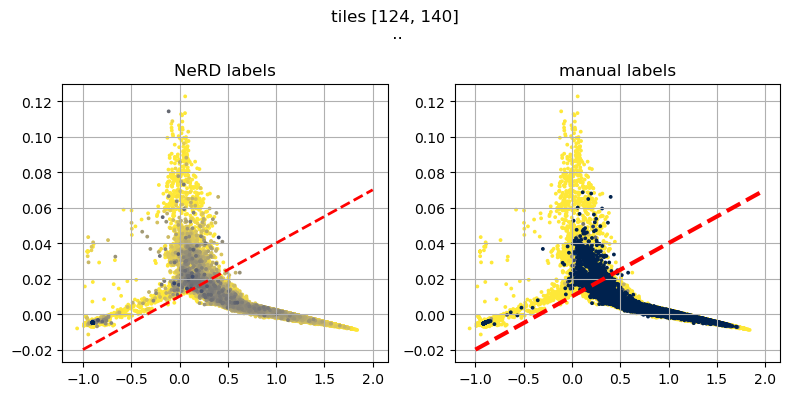

In [18]:
# def threshold_func(z0):
#     z1_val = dzdz*z0 + c 
#     return z1_val

# -- for model_1684233861 (16 may 23)
dzdz = (0.005)/(1)
dzdz = (0.06)/2
c = 0.01 #0 
print('z1 = a*z0 + c; a={}, c={}'.format( dzdz, c )) 
z0_seq = np.linspace(-1,2,50)
z1_t = dzdz*z0_seq + c 


''' ## Plot all label density '''
# fig,axs=plt.subplots(1,figsize=(4,4))
# ax=axs
# h=ax.scatter(
#     X[ np.argsort(y1),0] ,X[ np.argsort(y1),1] ,2, 
#     color=[0.2,0.2,0.2],alpha=alpha  #edgecolors="k"
# )
# # plot_latentspace_clusters(data_da_all['data'],encoded_labels_nerd['labels'].values,figsize=(5,5), ax=ax,cmap='cividis_r')#,alpha=0.1) # cividis_r
# ax.grid('on'); 
# ax.plot(z0_seq, z1_t,'r--',linewidth=2)
# ax.set_title('All px'.format(tile_nums))



'''## Label colors: nerd & manual'''
print('')
fig,axs=plt.subplots(1,2,figsize=(8,4))

ax=axs[0]
h=ax.scatter(
    X[ np.argsort(y1),0] ,X[ np.argsort(y1),1] ,3, 
    c=np.sort(y1,axis=0), cmap='cividis_r'  #edgecolors="k"
)
# plot_latentspace_clusters(data_da_all['data'],encoded_labels_nerd['labels'].values,figsize=(5,5), ax=ax,cmap='cividis_r')#,alpha=0.1) # cividis_r
ax.grid('on'); 
ax.plot(z0_seq, z1_t,'r--',linewidth=2)
ax.set_title('NeRD labels'.format(tile_nums))

ax=axs[1]
h=ax.scatter(
    X[ np.argsort(y0),0] ,X[ np.argsort(y0),1] ,3, 
    c=np.sort(y0,axis=0), cmap='cividis_r'  #edgecolors="k"
)
ax.grid('on'); 
ax.plot(z0_seq, z1_t,'r--',linewidth=3)
ax.set_title('manual labels'.format(tile_nums))

fig.suptitle('tiles {}\n ..'.format(tile_nums) )

fig.tight_layout()

## Extract labels with cluster: based on px density rather than label colors

z1 = a*z0 + c; a=0.03, c=0.01


Text(0.5, 1.0, 'Embedded pixels \n label=1')

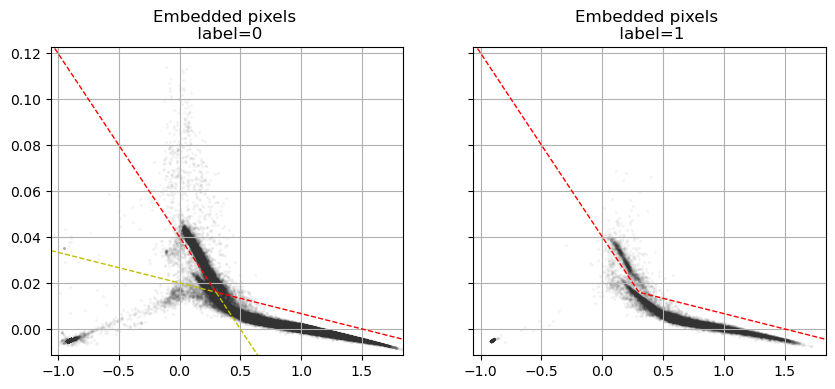

In [19]:


'''## Label split label=0 and label=1'''

idx_ManL_1 = (labels_np1 > 0).ravel() # 18776 samples
encoded_data_ManL1 = encoded_data['data'].values[idx_ManL_1,:] # 18776 samples
encoded_data_ManL0 = encoded_data['data'].values[~idx_ManL_1,:] # 18776 samples

## Split, For all tiles:
idx_ManL_1 = (encoded_labels_manual['labels'].values > 0).ravel() # 781250 samples
encoded_data_ManL1 = data_da_all['data'].values[idx_ManL_1,:] # 781250 samples
encoded_data_ManL0 = data_da_all['data'].values[~idx_ManL_1,:] 


''' ## Create line '''

xlim = [np.nanmin(encoded_data_ManL0[:,0]),np.nanmax(encoded_data_ManL0[:,0])]
ylim = [np.nanmin(encoded_data_ManL0[:,1]),np.nanmax(encoded_data_ManL0[:,1])]
z0_seq = np.linspace(xlim[0],xlim[1],len(encoded_data_ManL0[:,0]) )

# -- for model_1684233861 (16 may 23)
dzdz = (0.06)/2
c = 0.01 #0 
print('z1 = a*z0 + c; a={}, c={}'.format( dzdz, c )) 
# z0_seq_v0 = np.linspace(-1,2,50)
z1_t_v0 = dzdz*z0_seq + c 

# -- split on density; model_1684233861 (16 may 23)
z1_part1 = -(0.02)/0.25  * z0_seq + 0.04 
z1_part2 = -(0.02)/(1.5) * z0_seq + 0.02


## SELECT GROUPS:
# px should be SMALLER THAN z1_part1 as long as z1_part1 > z1_part2
# px should be SMALLER THAN z1_part2 when z1_part1 < z1_part2
# --> so first condition before z0_split_point and second condition after z0_split_point
idx_split_left = z1_part1 >= z1_part2
idx_split_right = z1_part1 < z1_part2

z1_seq = np.concatenate( [ z1_part1[idx_split_left], z1_part2[idx_split_right] ] )

''' ## PLOT  ''' 

alpha=0.03

fig,axs=plt.subplots(1,2,figsize=(10,4),sharex=True, sharey=True)
ax=axs[0]
ax.scatter(encoded_data_ManL0[:,0],encoded_data_ManL0[:,1], s=2,
           alpha=alpha,color=[0.2, 0.2, 0.2], )# cividis_r
# ax.plot(z0_seq, z1_t_v0,'y--',linewidth=1)
ax.plot(z0_seq, z1_seq,'r--',linewidth=1)
# ax.plot(z0_seq[idx_split_left],  z1_part1[idx_split_left], 'r--',linewidth=1)
ax.plot(z0_seq[idx_split_right], z1_part1[idx_split_right],'y--',linewidth=1)
ax.plot(z0_seq[idx_split_left],  z1_part2[idx_split_left], 'y--',linewidth=1)
# ax.plot(z0_seq[idx_split_right], z1_part2[idx_split_right],'r--',linewidth=1)
ax.set_xlim(xlim); ax.set_ylim(ylim); ax.grid('on'); 
ax.set_title('Embedded pixels \n label=0'.format(alpha))
# xlim_a = ax.get_xlim()

ax=axs[1]
ax.scatter(encoded_data_ManL1[:,0],encoded_data_ManL1[:,1], s=2,
           alpha=alpha,color=[0.2, 0.2, 0.2], )# cividis_r
# ax.plot(z0_seq, z1_t_v0,'y--',linewidth=1)
ax.plot(z0_seq, z1_seq,'r--',linewidth=1)
ax.set_xlim(xlim); ax.set_ylim(ylim); ax.grid('on'); 
ax.set_title('Embedded pixels \n label=1'.format(alpha))

## Plot selected groups

# fig,axs=plt.subplots(1,figsize=(5,4))
# ax=axs
# ax.scatter(data_da_all['data'].values[:,0],data_da_all['data'].values[:,1], s=2,
#            alpha=alpha,color=[0.2, 0.2, 0.2], )# cividis_r
# # ax.plot(z0_seq, z1_t_v0,'y--',linewidth=1)
# ax.plot(z0_seq, z1_seq,'r--',linewidth=1)
# # ax.plot(z0_seq, z1_part2,'r--',linewidth=1)
# ax.set_xlim(xlim); ax.set_ylim(ylim); ax.grid('on'); 
# ax.set_title('Embedded pixels \n all'.format(alpha))


In [20]:
# # conditions:
# group_0 = 
# group_1 = 
# group_2 = 
# group_3 = 


In [22]:
# # plt.plot(z0_sorted, z1_sorted)
# # plt.plot(z0_seq, z1_seq)

# # plt.plot(z0_sorted, z0_seq)
# len(z0_sorted)
# len(z0_seq)
# print( z0_sorted.shape)  # (390625,)
# print( z0.shape) # (390625,)

# z0_seq = np.linspace(np.nanmin(z0),np.nanmax(z0),num=len(z0) )
# print(z0_seq.shape)

In [ ]:
print(z0_seq[0:10])
print(z0_sorted[0:10])


plt.plot(z0_seq, -(0.02)/0.25  * z0_seq + 0.04 )
plt.plot(z0_sorted,  -(0.02)/0.25  * z0_sorted + 0.04 )

In [ ]:
len(idx_cluster_sorted)

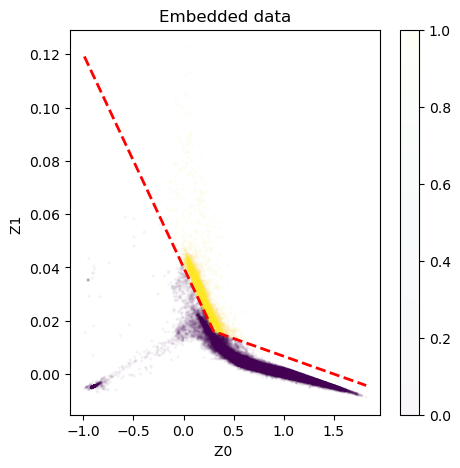

In [23]:
z0 = encoded_data['data'].values[:,0]
z1 = encoded_data['data'].values[:,1]

## Sort latent space values so can threshold values of Z1 based on Z0
i_sort = np.argsort(z0)
z1_sorted = z1[i_sort]
z0_sorted = z0[i_sort]


## Define pixels that are in cluster

# the threshold-array: a combination of two lines
z0_seq = np.linspace(np.nanmin(z0),np.nanmax(z0),num=len(z0) )
# z1_treshold_val = dzdz*z0_seq + c  
# z1_part1 = -(0.02)/0.25  * z0_seq + 0.04 
# z1_part2 = -(0.02)/(1.5) * z0_seq + 0.02
z1_part1 = -(0.02)/0.25  * z0_sorted + 0.04 
z1_part2 = -(0.02)/(1.5) * z0_sorted + 0.02
# combine the two lines
idx_split_left = z1_part1 >= z1_part2 
idx_split_right = z1_part1 < z1_part2
z1_seq = np.concatenate( [ z1_part1[idx_split_left], z1_part2[idx_split_right] ] )

print('z0 {}, z0_seq {}, z1_seq {}'.format(z0.shape, z0_seq.shape, z1_seq.shape) )

# condition: px should be greater than threshold line
# to do: interpolate samples to same array as z0_seq
idx_cluster_sorted = np.greater(z1_sorted, z1_seq).astype(int)

fig,axs=plt.subplots(1,figsize=(5,5))
ax=axs#[1]
h=ax.scatter(z0_sorted,z1_sorted,c=idx_cluster_sorted ,s=2, cmap='viridis',
             alpha=alpha )
# h=ax.scatter(z0_sorted[idx_cluster_sorted],z1_sorted[idx_cluster_sorted],color='red' ,s=2 )
# h=ax.scatter(z0_sorted[~idx_cluster_sorted],z1_sorted[~idx_cluster_sorted],color='blue' ,s=2,alpha=1 )

# h=ax.scatter(z0_seq,z1_sorted,3,c=idx_cluster_sorted )
ax.plot(z0_sorted, z1_seq,'r--',linewidth=2)
# ax.plot(ax.get_xlim(), ax.get_xlim(),'k--'); ax.grid('on')
ax.set_xlabel('Z0 ')
ax.set_ylabel('Z1 ')
ax.set_title("Embedded data")
fig.colorbar(h)

## extract clusters with line (based on NeRD labels)

In [24]:
# # def threshold_func(z0):
# #     z1_val = dzdz*z0 + c 
# #     return z1_val

# # -- for model_1674725058 (26jan 23)
# dzdz = (0.005)/(1)
# c = -0.005 #0 
# print('z1 = a*z0 + c; a={}, c={}'.format( dzdz, c )) 
# z0_seq = np.linspace(-3,1,50)
# z1_t = dzdz*z0_seq + c 



# fig,axs=plt.subplots(1,figsize=(5,5))
# ax=axs#[1]
# h=ax.scatter(
#     X[ np.argsort(y1),0] ,X[ np.argsort(y1),1] ,3, 
#     c=np.sort(y1,axis=0), cmap='cividis_r'  #edgecolors="k"
# )
# ax.plot(z0_seq, z1_t,'r--',linewidth=3)
# # ax.plot(ax.get_xlim(), ax.get_xlim(),'k--'); ax.grid('on')
# ax.set_xlabel('X1 ')
# ax.set_ylabel('X2 ')
# ax.set_title("Embedded data X1/X2 (NeRD labels)")
# # ax.set_xlim([0,5])
# fig.colorbar(h)
# ax.grid('on')

### fit SVM to extract cluster

In [25]:
# import time
# # train
# start_time = time.time()
# clf0 = make_pipeline(StandardScaler(), SVC(gamma='auto'))
# clf0.fit(X_train, y_train0)
# print("Elapsed time train0: {} min ".format( (time.time() - start_time)/60 ))


# # train
# start_time = time.time()
# clf1 = make_pipeline(StandardScaler(), SVC(gamma='auto'))
# clf1.fit(X_train, y_train1)

# print("Elapsed time train1: {} min ".format( (time.time() - start_time)/60 ))


In [26]:

# start_time = time.time()
# predict_class= clf0.predict(X_test)

# print("Elapsed time train0: {} min ".format( (time.time() - start_time)/60 ))

In [27]:
# %matplotlib inline

# fig,axs=plt.subplots(1,2,figsize=(12,4))

# ax=axs[0]
# h=ax.scatter(
#     X_train[ np.argsort(y_train0),0] ,X_train[ np.argsort(y_train0),1] ,3, 
#     c=np.sort(y_train0,axis=0), cmap='cividis_r'  #edgecolors="k"
# )
# # ax.plot(ax.get_xlim(), ax.get_xlim(),'k--'); ax.grid('on')
# ax.set_xlabel('X1 train')
# ax.set_ylabel('X2 train')
# ax.set_title("SVC train set (manual labels)")
# # ax.set_xlim([0,5])
# fig.colorbar(h)


# ax=axs[1]
# h=ax.scatter(
#     X_train[ np.argsort(y_train1),0] ,X_train[ np.argsort(y_train1),1] ,3, 
#     c=np.sort(y_train1,axis=0), cmap='cividis_r'  #edgecolors="k"
# )
# # ax.plot(ax.get_xlim(), ax.get_xlim(),'k--'); ax.grid('on')
# ax.set_xlabel('X1 train')
# ax.set_ylabel('X2 train')
# ax.set_title("SVC train set (NeRD labels)")
# # ax.set_xlim([0,5])
# fig.colorbar(h)


# ''' Test set''' 

# fig,axs=plt.subplots(1,2,figsize=(12,4))

# ax=axs[0]
# h=ax.scatter(
#     X_train[ np.argsort(y_test0),0] ,X_train[ np.argsort(y_test0),1] ,3, 
#     c=np.sort(y_test0,axis=0), cmap='cividis_r'  #edgecolors="k"
# )
# # ax.plot(ax.get_xlim(), ax.get_xlim(),'k--'); ax.grid('on')
# ax.set_xlabel('X1 test')
# ax.set_ylabel('X2 test')
# ax.set_title("SVC test set (manual labels)")
# # ax.set_xlim([0,5])
# fig.colorbar(h)


# ax=axs[1]
# h=ax.scatter(
#     X_train[ np.argsort(y_test1),0] ,X_train[ np.argsort(y_test1),1] ,3, 
#     c=np.sort(y_test1,axis=0), cmap='cividis_r'  #edgecolors="k"
# )
# # ax.plot(ax.get_xlim(), ax.get_xlim(),'k--'); ax.grid('on')
# ax.set_xlabel('X1 test')
# ax.set_ylabel('X2 test')
# ax.set_title("SVC test set (NeRD labels)")
# # ax.set_xlim([0,5])
# fig.colorbar(h)

# Apply clustering to all AIS data
- make proper prediction by loading a tile, embedding, and extracting cluster
- This means that I need to load all tile anew, do noramlisation, etc


In [28]:
# tile_nums = [0, 3, 4, 42, 51, 52, 53, 54, 55, 124, 140, 276, 285, 286] # all tiles in DJF 19-20 tht have mnual labels; # exlcuding 61


In [59]:
def create_cutouts3(da,cutout_size, dropna=True, fillna=False):

    # generate windows
    da = da.rolling(x=cutout_size, y=cutout_size)
    da = da.construct({'x': 'x_win', 'y': 'y_win'}, stride=cutout_size)

    # drop NaN-containing windows
    da = da.stack(sample=('x', 'y'))
    if dropna:
        da = da.dropna(dim='sample', how='any')
    if fillna: # can be either 'True' or a value (float/int). If no value is specified, use -999
        if isinstance(fillna,bool):
            fillna=-999
        da = da.fillna(fillna)

    # tile_cutouts = da.data.transpose(3, 1, 2, 0) # samples, x_win, y_win, bands: (250000, 20, 20, 3)
    # tile_cutouts_da = da.transpose('sample','x_win','y_win','band')
    
    tile_cutouts_da = da.transpose('sample','x_win','y_win' ,...) # transpose dimensionos; dataArray does nto necessarily need 'band' as dimension
    # tile_cutouts = tile_cutouts_da.data
    
    return tile_cutouts_da



---- Loading S2_composite_2019-11-1_2020-3-1_tile_140
cutouts (391876, 20, 20, 3) 


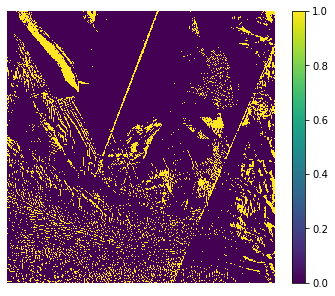

In [60]:
# 
normThreshold = [15000]
adaptHist = True
from skimage import exposure as skimage_exposure

for tileNum in [140]: # 52,53,54]:
        
    tile_file = os.path.join(tiles_path,'S2_composite_2019-11-1_2020-3-1_tile_' + str(tileNum) + '.tif')
    tileName = tile_file.split("/")[-1][:-4] # vb: 'S2_composite_2019-11-1_2020-3-1_tile_124'
    print('---- Loading ' + tileName )

    # Laod encoder -- all gedaan in deze notebook
    
#     epoch_num = path_to_encoder_epoch.split('_')[-1]
#     encoder = tf.keras.models.load_model(path_to_encoder_epoch,compile=False) # compile=True does not work
    
#     # Get latent_dim (of sampling layer)
#     latent_dim = encoder.layers[-1].output_shape[-1] 

    
    ''' ---------- Load tile ------------'''
    # read tile - floats are required to mask with NaN's
    da = rioxr.open_rasterio(tile_file).astype("float32")
    da = da.isel(band=[0,1,2])
    
    
    ''' ---------- Maks ocean (do later) ------------'''
    # mask/clip: if self.mask is not None: [removed; see _generate_cutouts]
    # da = mask_data(da,oceanmask_file)


    ''' ---------- Normalise and Equalise------------''' 
    da = normalise_and_equalise(da,normThreshold=normThreshold[0],equalise=adaptHist)
    

    ''' ---------- Generate cutouts: without dropping NaN windows (either keep NaN, or fill) ------------'''

    # generate windows -- cut 
    # TO UPDATE: create_cutouts2 drops NaN containing windows -- either fill NaN with -999 or some other value when embedding tiles for predictions
    tile_cutouts_da = create_cutouts3(da,cutout_size,dropna=False) 
    print('cutouts {} '.format(tile_cutouts_da.shape))


    ''' ----------
    Load encoded input // encode more 
    Encode here rather than loading encoded tile (or update the encoding.py script) 
    - In training flow all nan-containing windows had to be dropped, but here I need to keep them.
    - Maybe the encoder cannot handle NaN data -- in that case, fill with -999 or smth and store mask to remove these windows later on.

    ------------'''

    # encoded_data_file = os.path.join(path_to_model, tileName + "_encoded" + '_epoch'+str(epoch_num) +".npy")
    # if os.path.exists(encoded_data_file):
    #     # read file
    #     encoded_data = np.load(encoded_data_file) # np.array
    #     # to xr.dataArray
    #     encoded_data = xr.DataArray(data=encoded_data, dims=['samples','ldim'], 
    #                          coords={'samples':np.arange(0,len(encoded_data)),'ldim':np.arange(0,latent_dim)}).to_dataset(name='data')
    # # else:
    #     ''' ------- Do encoding (other script) ------'''

    # encoded_data = 

    encoded_data # dataArray 
    encoded_data,_,_ = encoder.predict(tile_cutouts_da.data);

    z0 = encoded_data[:,0]
    z1 = encoded_data[:,1]
    

    ''' ----------
    Predict cluster type for all pixels: SVM
    ------------'''

    #     tile_X_df = encoded_data['data'].to_pandas()
    #     tile_X_df.columns=['z0','z1','z2']
    #     # tile_X_df = tile_X_df.dropna(axis='index',how='any')#.sample(10000,random_state=42)

    #     ## use cluster predictino based on manual labels
    #     tile_y_predict = clf0.predict(tile_X_df.values)     ## np ndarray with (Nsamples,)

    #     # Put back into xarray
    #     # tile_y_pred_da = xr.DataArray(data=encoded_data, dims=['samples','y_pred'], 
    #     #                          coords={'samples':np.arange(0,len(encoded_data)),'y_pred':np.arange(0,1)}).to_dataset(name='data')

    #     print(np.unique(tile_y_predict))

    ''' ----------
    Predict cluster type for all pixels: Threshold
    ------------'''

    ## Sort latent space values so can threshold values of Z1 based on Z0
    i_sort = np.argsort(z0)
    z1_sorted = z1[i_sort]
    z0_sorted = z0[i_sort]
    
    # set up sequence for x-axis
    z0_seq = np.linspace(np.nanmin(z0),np.nanmax(z0),len(z0) )
    
    
    ## -- define threshold value
    # -- for model_1674725058 (26jan 23)
    # dzdz = (0.005)/(1)
    # c = -0.005 #0 
    # print('z1 = a*z0 + c; a={}, c={}'.format( dzdz, c )) 
    # z0_seq = np.linspace(np.nanmin(z0),np.nanmax(z0),len(z0) )
    # z1_treshold_val = dzdz*z0_seq + c  # linear line
    
    ## -- for model_1684233861 (16 may 23)
#     dzdz = (0.005)/(1)
#     dzdz = (0.06)/2
#     c = 0.01 #0 
#     print('z1 = a*z0 + c; a={}, c={}'.format( dzdz, c )) 
#     z0_seq = np.linspace(np.nanmin(z0),np.nanmax(z0),len(z0) )
#     z1_treshold_val = dzdz*z0_seq + c 

#     # -- extract samples in cluster
#     # idx_cluster_sorted = np.less(z1_sorted, z1_treshold_val).astype(int)
#     idx_cluster_sorted = np.greater(z1_sorted, z1_treshold_val).astype(int)
    
    
    ## --  Define threshold based on 2-line combi: 
    ##     split on density; model_1684233861 (16 may 23)
    z1_part1 = -(0.02)/0.25  * z0_seq + 0.04 
    z1_part2 = -(0.02)/(1.5) * z0_seq + 0.02
    # z1_part1 = -(0.02)/0.25  * z0_sorted + 0.04 
    # z1_part2 = -(0.02)/(1.5) * z0_sorted + 0.02
    
    # combine the two lines
    idx_split_left = z1_part1 >= z1_part2 
    idx_split_right = z1_part1 < z1_part2
    z1_seq = np.concatenate( [ z1_part1[idx_split_left], z1_part2[idx_split_right] ] )

    # -- extract samples in clustercondition: px should be greater than threshold line
    idx_cluster_sorted = np.greater(z1_sorted, z1_seq).astype(int)


    ## -- Reverse sort of latent space to recover spatial relations of samples
    idx_cluster = idx_cluster_sorted[np.argsort(i_sort)] # (Nsamples)
    
    ''' ----------
    Put predicted labels in dataArray
    ------------'''
    # place the cluster indices in an xarray and unstack to spatial img

    idx_cluster_da = tile_cutouts_da.isel(band=0,x_win=0,y_win=0).copy(deep=True, data=idx_cluster) # (Nsamples)
    cluster_da     = idx_cluster_da.unstack().transpose('y','x') # (Nsamples) --> (x, y) 
    # # labels_da = labels_ldim_da.unstack().transpose('band','y','x')

    fig,ax=plt.subplots(figsize=(6,5))
    cluster_da.plot.imshow(ax=ax,label=''); ax.set_axis_off(); ax.set_title('');

In [93]:

# ''' ----------
# Predict cluster type for all pixels: Threshold
# ------------'''

# ## Sort latent space values so can threshold values of Z1 based on Z0
# i_sort = np.argsort(z0)
# z1_sorted = z1[i_sort]
# z0_sorted = z0[i_sort]

# # set up sequence for x-axis
# z0_seq = np.linspace(np.nanmin(z0),np.nanmax(z0),len(z0) )

# ## --  Define threshold based on 2-line combi: 
# ##     split on density; model_1684233861 (16 may 23)

# # z1_part1 = -(0.02)/0.25  * z0_sorted + 0.04 
# # z1_part2 = -(0.02)/(1.5) * z0_sorted + 0.02
# z1_part1 = -(0.02)/0.25  * z0_seq + 0.04 
# z1_part2 = -(0.02)/(1.5) * z0_seq + 0.02
# # combine the two lines
# idx_split_left = z1_part1 >= z1_part2 
# idx_split_right = z1_part1 <= z1_part2

# z1_seq = np.concatenate( [ z1_part1[idx_split_left], z1_part2[idx_split_right] ] )


# print('z0, z1       {}, {},\n' \
#       'z0_seq       {},\n' \
#       'z0/z1 sorted {}, {}\n' \
#       .format(z0.shape,z1.shape, z0_seq.shape, z0_sorted.shape,z1_sorted.shape) )
      
    
# print('idx_left  {},\n' \
#       'idx_right {},\n' \
#       'z1_seq    {}\n'.format(idx_split_left.shape, idx_split_right.shape, z1_seq.shape) )

# print('z1_part1  {},\n' \
#       'z1_part2  {},\n' \
#       'z1_seq    {}\n'.format(z1_part1.shape, z1_part2.shape, z1_seq.shape) )

# print('z1_part1 ileft   {},\n' \
#       'z1_part2 iright  {},\n' \
#       'z1_seq    {}\n'.format(z1_part1[idx_split_left].shape,  z1_part2[idx_split_right].shape, z1_seq.shape) )

# print('idx_split as integer, sum: {}'.format(idx_split_right.astype(int).sum()+ idx_split_left.astype(int).sum() ) )


# print(np.unique(idx_split_right.astype(int)))

# ileft  = np.greater(    z1_part1, z1_part2 ,out= np.ones(z0_seq.shape) ).astype(int)
# iright = np.less_equal( z1_part1, z1_part2 ,out= np.ones(z0_seq.shape) ).astype(int)
# z1_seq2 = np.concatenate( [ z1_part1[ileft], z1_part2[iright] ] )

# print('idx_left  {},\n' \
#       'idx_right {},\n' \
#       'z1_seq    {}\n'.format(ileft.shape, iright.shape, z1_seq2.shape) )

# print('z1_part1 ileft   {},\n' \
#       'z1_part2 iright  {},\n' \
#       'z1_seq    {}\n'.format(z1_part1[ileft].shape,  z1_part2[iright].shape, z1_seq2.shape) )

# # # # -- extract samples in clustercondition: px should be greater than threshold line
# # idx_cluster_sorted = np.greater(z1_sorted, z1_seq).astype(int)
# z1_part1[ileft]


Text(0.5, 1.0, 'Embedded pixels \n all')

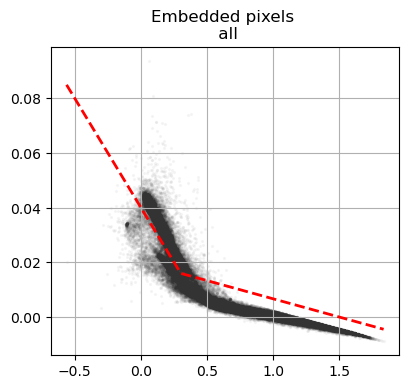

In [108]:

## Plot selected groups

fig,axs=plt.subplots(1,figsize=(4.5,4))
ax=axs
ax.scatter(z0,z1, s=2,
           alpha=alpha,color=[0.2, 0.2, 0.2], )# cividis_r
# ax.plot(z0_seq, z1_t_v0,'y--',linewidth=1)
# ax.plot(z0_seq, z1_part1,'y--',linewidth=1)
# ax.plot(z0_seq, z1_part2,'y--',linewidth=1)
ax.plot(z0_seq, z1_seq,'r--',linewidth=2)
# ax.set_xlim(xlim); ax.set_ylim(ylim); 
ax.grid('on'); 
ax.set_title('Embedded pixels \n all'.format(alpha))

In [ ]:

# fig,ax=plt.subplots(figsize=(6,5))
# cluster_da.plot.imshow(ax=ax,label=''); ax.set_axis_off(); ax.set_title('');

In [96]:
''' ----------
Load Labels: shapefiles
------------'''
# labels_path = /projects/0/einf512/labels
catalog_path = '/projects/0/einf512/S2_composite_catalog'
# # read tile catalog to be able to get CRS and filter labels to same date
catalog = ts._read_tile_catalog(catalog_path)
tiles = ts._catalog_to_geodataframe(catalog)

labels = ts._read_labels(labels_path, verbose=True)
labels = labels.to_crs(tiles.crs)  # make sure same CRS is used. NB: at this stage, 


idx_NaT = ~labels['Date'].notnull() # all NaT indices are 'True'
labels.loc[idx_NaT,'Date'] = pd.to_datetime('2020-01-01')
      
# select the only labels matching the tiles timespan
labels = ts._filter_labels(labels,
                        tiles.start_datetime.min(),
                        tiles.end_datetime.max())

## Create GeoSeries from labels.geometry
label_polys = gpd.GeoSeries(labels.geometry,crs=labels.crs) # Combine all geometries to one GeoSeries, with the 
# remove empty geoms
label_polys= label_polys.loc[~label_polys.is_empty]
      
# create polygon mask
labels_tileraster = geometry_mask( label_polys.to_crs(da.rio.crs).geometry,
            out_shape=da.isel(band=0).shape, #ds.geobox.shape,
            transform=da.rio.transform(), # ds.geobox.affine,
            all_touched=True,
            invert=True)
labels_tileraster = labels_tileraster.astype(np.dtype('uint16')) # np ndarray (x , y)

labels_da = da.isel(band=0).copy( data=labels_tileraster ).expand_dims(dim='band')  # ( y, x)
labels_da.attrs['name']='label'
labels_da.attrs['long_name']='manual_label'

Labels successfully read from 18 files
Selecting 996 out of 1274 labels


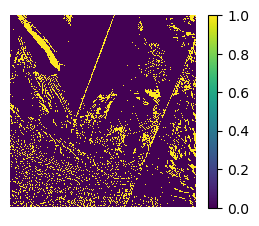

In [97]:



''' ----------
Put predicted labels in dataArray
------------'''
# place the cluster indices in an xarray and unstack to spatial img

idx_cluster_da = tile_cutouts_da.isel(band=0,x_win=0,y_win=0).copy(deep=True, data=idx_cluster) # (Nsamples)
idx_cluster_da
# idx_cluster_da = labels_ldim_da.copy(deep=True, data=idx_cluster) # (Nsamples,1)
cluster_da = idx_cluster_da.unstack().transpose('y','x') # (x, y) 
# # labels_da = labels_ldim_da.unstack().transpose('band','y','x')

fig,ax=plt.subplots(figsize=(3,2.5))
cluster_da.plot.imshow(ax=ax,label=''); ax.set_axis_off(); ax.set_title('');



In [98]:

# def clip_da_to_iceshelf(data_da, iceshelf_polygon_gpd,drop=False):
#     ''' Clip data (xarray.DataArray) to ice shelf polygon file (geopandas.DataFrame) '''
#     return data_da.rio.clip( iceshelf_polygon_gpd.geometry, iceshelf_polygon_gpd.crs, drop=drop, invert=False)

## clip to ocean
oceanmask_file = '/projects/0/einf512/ne_10m_antarctic_ice_shelves_polys/ne_10m_antarctic_ice_shelves_polys.shp'
# ocean_poly = gpd.read_file(oceanmask_file).to_crs(epsg=3031)
da_mask = mask_data(da,oceanmask_file)
cluster_mask = mask_data(cluster_da,oceanmask_file)
ocean_mask= xr.where(np.isnan(da_mask.isel(band=0)), 1, np.nan)

# ocean_mask


KeyboardInterrupt: 

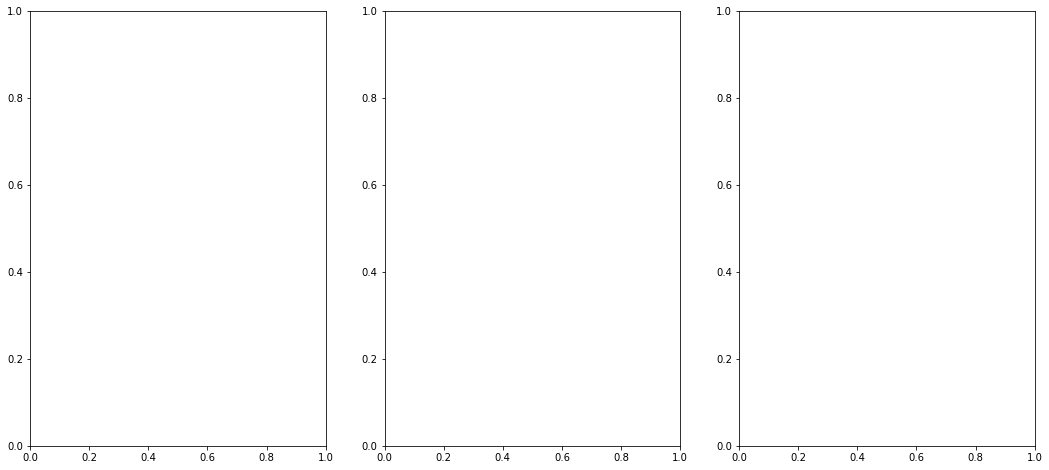

In [61]:
# overlap clusters with tile_da
# da = tile_da.isel(band=[0,1,2])


# Plot tile

fig,axs= plt.subplots(1,3,figsize=(18,8))

# --  img 

ax=axs[0]
da.attrs['long_name']='imgbands';
da.plot.imshow(ax=ax,rgb='band', vmin=0,vmax=1,cmap='gray',add_colorbar=True)
ax.set_aspect('equal')
ax.set_title('Input',fontsize=14)
ax.set_axis_off()

# --  img with  labels

ax=axs[1]
da.attrs['long_name']='imgbands';
da.plot.imshow(ax=ax,rgb='band', vmin=0,vmax=1,cmap='gray',add_colorbar=True)
ax.set_aspect('equal')
# original labels
# labels_da.transpose('band','y','x').where(labels_da>0).isel(band=0).plot.contour(ax=ax)
labels_da.transpose('band','y','x').where(labels_da>0).isel(band=0).plot(ax=ax,vmin=0,vmax=1,add_colorbar=False)#.contour(ax=ax)
ax.set_title('Labels',fontsize=14)
ax.set_axis_off()

# -- img with cluster laels 

ax=axs[2]
da.attrs['long_name']='imgbands';
da.plot.imshow(ax=ax,rgb='band', vmin=0,vmax=1,cmap='gray',add_colorbar=True)
ocean_mask.plot.imshow(ax=ax,cmap='pink',alpha=0.8,add_colorbar=False)
ax.set_aspect('equal')
# detected cluster
cluster_mask.plot.contour(ax=ax)
ax.set_title('Predicted',fontsize=14)
ax.set_axis_off()

In [62]:
ax=plt.axes()
da.attrs['long_name']='imgbands';
da.plot.imshow(ax=ax,rgb='band', vmin=0,vmax=1,cmap='gray',add_colorbar=True)
ocean_mask.plot.imshow(ax=ax,cmap='pink',alpha=0.8,add_colorbar=False)
ax.set_aspect('equal')
# detected cluster
cluster_mask.plot.contour(ax=ax)
ax.set_title('Predicted',fontsize=14)
ax.set_axis_off()

NameError: name 'ocean_mask' is not defined

Error in callback <function flush_figures at 0x13360e7a0> (for post_execute):


## Evaluate agains NeRD labels

In [100]:
dmg_path = '/projects/0/einf512/NERD/damage_detection/'
dmg_file = os.path.join(dmg_path,'S2_composite_2019-11-1_2020-3-1_tile_' + str(tileNum) + '_300m_damageContin.tif')
crevSig_file = os.path.join(dmg_path,'S2_composite_2019-11-1_2020-3-1_tile_' + str(tileNum) + '_output_10px_crevSig.tif')
# dmg_file = os.path.join(dmg_path,'dmg_SON_2019_tile_' + str(tileNum) + '.tif')

# if DMG file not availalbe, try crevSig file. For 30m:10px , threshold =0.04
# ...
if os.path.exists(dmg_file):
    data_dmg = rioxr.open_rasterio(dmg_file).astype("float32")
elif os.path.isfile(crevSig_file):
    data_crevSig = rioxr.open_rasterio(crevSig_file).astype("float32")
    data_dmg = data_crevSig - 0.04   #threshold for S2 30m-10px
    data_dmg = data_dmg.where(data_dmg>0, other=0) # only keep positive values
else:
    print('No dmg or crevSig file found:\n {} \n {}'.format(dmg_file, crevSig_file))

# interpolate dmg to same resolution as tile (to link as labels)
tile_dmg = data_dmg.isel(band=0).interp_like(da.isel(band=0))
tile_dmg = tile_dmg.fillna(0).expand_dims(dim='band') # fill nan with zeros and add band-dim 


In [ ]:
# cluster_mask.plot.imshow(vmin=0,vmax=1)

In [ ]:
# cluster_mask.min() # -9223372036854775808
# cluster_mask.max() # 1
# cluster_mask = cluster_mask.where(cluster_mask>0)


In [109]:
import rasterio as rio

cluster_mask # (626, 626)
tile_dmg # (12505; 12502)

## interpolate predicted dmg to original tile grid -- with interp_like cannot set nodata value... 
tile_predicted_labels = cluster_mask.where(cluster_mask>0,other=0).interp_like(da.isel(band=0))#,nodata=np.nan)# ,fill_value=np.nan)




In [110]:
# tile_predicted_labels.plot.imshow()#vmin=0,vmax=1)


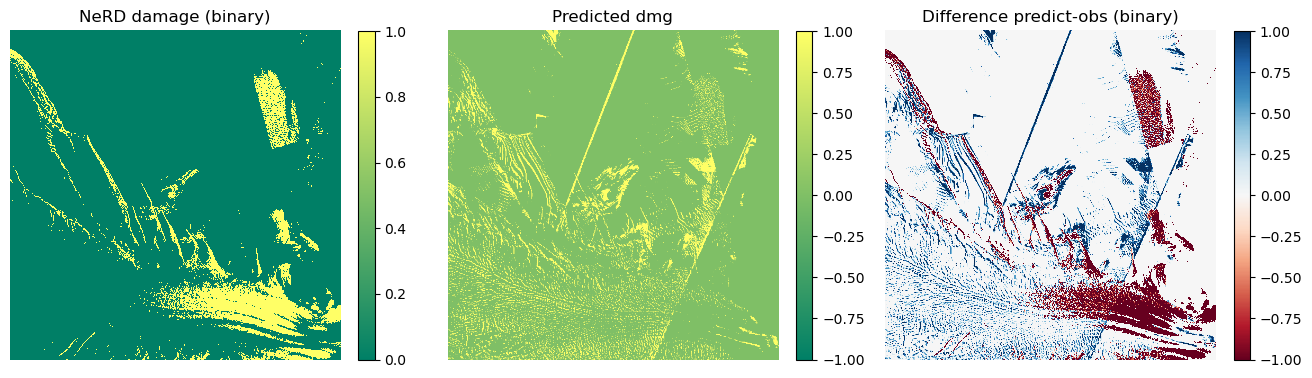

In [111]:
tile_dmg_binary = xr.where(tile_dmg > 0, 1,0) # binarize dmg values

## Difference predicted - nerd
diff_dmg = tile_predicted_labels - tile_dmg_binary

fig,axs=plt.subplots(1,3,figsize=(16,5))
ax=axs[0]
tile_dmg_binary.isel(band=0).plot.imshow(ax=ax, 
                                  cmap='summer',
                                  cbar_kwargs={'fraction':0.045})
ax.set_title('NeRD damage (binary)'); ax.set_aspect('equal'); ax.set_axis_off();
ax=axs[1]
tile_predicted_labels.plot.imshow(ax=ax, cmap='summer',
                                  cbar_kwargs={'fraction':0.045})
ax.set_title('Predicted dmg'); ax.set_aspect('equal'); ax.set_axis_off();
ax=axs[2]
diff_dmg.isel(band=0).plot.imshow(ax=ax, cmap='RdBu',
                                  cbar_kwargs={'fraction':0.045})
ax.set_title('Difference predict-obs (binary)'); ax.set_aspect('equal'); ax.set_axis_off();



## Test with rolling window (to get predictor ipv single value)

In [ ]:
# # overlap clusters with tile_da
# # da = tile_da.isel(band=[0,1,2])

# # labels_da = labels1

# # Plot tile

# fig,axs= plt.subplots(1,3,figsize=(18,8))

# # --  img 

# ax=axs[0]
# da.attrs['long_name']='imgbands';
# da.plot.imshow(ax=ax,rgb='band', vmin=0,vmax=1,cmap='gray',add_colorbar=True)
# ax.set_aspect('equal')
# ax.set_title('Input',fontsize=14)
# ax.set_axis_off()

# # --  img with  labels

# ax=axs[1]
# da.attrs['long_name']='imgbands';
# da.plot.imshow(ax=ax,rgb='band', vmin=0,vmax=1,cmap='gray',add_colorbar=True)
# ax.set_aspect('equal')
# # original labels
# # labels_da.transpose('band','y','x').where(labels_da>0).isel(band=0).plot.contour(ax=ax)
# labels_da.transpose('band','y','x').where(labels_da>0).isel(band=0).plot(ax=ax,vmin=0,vmax=1,add_colorbar=False)#.contour(ax=ax)
# ax.set_title('Labels',fontsize=14)
# ax.set_axis_off()

# # -- img with cluster laels 

# ax=axs[2]
# da.attrs['long_name']='imgbands';
# da.plot.imshow(ax=ax,rgb='band', vmin=0,vmax=1,cmap='gray',add_colorbar=True)
# ocean_mask.plot.imshow(ax=ax,cmap='pink',alpha=0.8,add_colorbar=False)
# ax.set_aspect('equal')
# # detected cluster
# cluster_mask.plot.contour(ax=ax)
# ax.set_title('Predicted',fontsize=14)
# ax.set_axis_off()